# Run a whole city by dividing it up in gridcells

1. [x] get city bounds
2. [x] convert that to utm
3. [x] create grid/sliding window
4. [x] convert to polygons
5. [x] write polygons to geojson

In [1]:
# get city outlines from OSM easily
import osmnx as ox

# geospatial operations on points, polygons, polylines (e.g. shapes) 
import shapely

# shapely function to create shapely object from GeoJSON
from shapely.geometry import shape, Polygon

# plotting tools 
import folium

# OSM api
import overpass


## dealing with files
# we use fiona to read shapefiles
import fiona
# we use ogr to write shapefiles
from osgeo import ogr

import matplotlib.pyplot as plt


from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint
from itertools import chain

from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union, unary_union
from shapely.affinity import translate
import fiona

In [2]:
def wgs2epsg(x,y):
    EPSG = int(32700-round((45+y)/90,0)*100+round((183+x)/6,0))
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code

## Define parameters

In [3]:
search_water = False

country_name = 'Indonesia'

cities = [
'Jakarta',
['Jakarta','Bogor','Depok','Tangerang','Bekasi'],
'Cilegon',
'Pekanbaru',
'Batam',
'Sabang',
'Solok',
'Semarang',
'Denpasar', 
'Balikpapan', 
'Pontianak', 
'Makassar',
'Binjai',            # additional 20?
'Medan',
'Bandar Lampung',
'Bukit Tinggi',
'Tanjung Balai',
'Sungai Penuh',
'Metro',
'Dumai',
'Pematang Siantar',
'Gunung Sitoli',
'Banda Aceh',
'Tangerang Selatan',
'Surakarta',
'Depok',
'Pekalongan']

# Get ocean

In [6]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../data/ne_10m_ocean/*.shp'
shape_files = glob.glob(shape_file_path)
path = shape_files[0]

shp_ocean = [shape(pol['geometry']) for pol in fiona.open(path)][0]
shp_ocean = shp_ocean.simplify(0.0001)
id_list = [pol['id'] for pol in fiona.open(path)]

cwd, shape_files, path

('/media/chris/ChrisBackup/GreenCityWatch/rimbun.io/notebooks',
 ['../../data/ne_10m_ocean/ne_10m_ocean.shp',
  '../../data/ne_10m_ocean/ne_10m_ocean_fixed_geometries.shp'],
 '../../data/ne_10m_ocean/ne_10m_ocean.shp')

# Get city

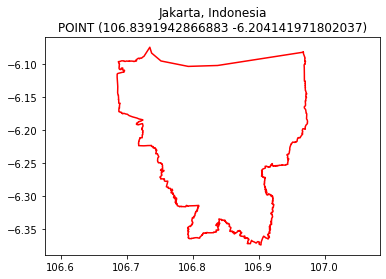

In [7]:
plot_shapes = True

shp_list_cities = []
shp_list_water = []
id_list_water = []

# initiate overpass API
api = overpass.API()

# for city in cities:

city_name = cities[0]

# sigle
if type(city_name) == str:
    city_query = '{}, {}'.format(city_name, country_name)
    ox_city = ox.gdf_from_place(city_query)
    shp_city_ox = ox_city.geometry
    
    shp_city_ox = [shp_city_ox]
    
# multiple cities
else:
    city_query = []
    for city in city_name:
        city_query.append('{}, {}'.format(city, country_name))
        
    ox_city = ox.gdf_from_places(city_query)
    shp_city_ox = ox_city.geometry


    
shp_city_list = []

for shp in shp_city_ox: 

    if shp[0].type == 'Point':
        shp = shp.buffer(0.1)

    if shp[0].type == 'LineString':
        shp = shp.centroid.buffer(0.01)
        
    shp_city_list.append(shp)
    
    
try:
    shp_city = cascaded_union(shp_city_list[0])
except Exception as e:
    print(e)
    print('no union needed')
    
try:
    shp_city_land = shp_city.difference(shp_ocean)
except Exception as e:
    print(e.message, e.args)
    shp_city_land = shp_city

try: 
    len(shp_city_land)
    x,y = shp_city_land[0].exterior.xy
except:
    x,y = shp_city_land.exterior.xy


shp_list_cities.append(shp_city_land)


if search_water:

    # get bounding box
    x_w, y_s, x_e, y_n = shp_city_land.bounds

    # get water
    # create a Query
    query_way = 'way["natural"="water"]["waterway"!="riverbank"]["water"!="river"]({0},{1},{2},{3});(._;>;)'.format(y_s, x_w, y_n, x_e)
    query_relation = 'relation["natural"="water"]["waterway"!="riverbank"]["water"!="river"]({0},{1},{2},{3});(._;>;)'.format(y_s, x_w, y_n, x_e)

    try:
        response_way = api.get(query_way, responseformat="geojson", verbosity='geom')
        response_relation = api.get(query_relation, responseformat="geojson", verbosity='geom')
        OSM_data = [f for f in chain(response_way.features, response_relation.features) if (f.geometry['type'] == "LineString" and len(f.geometry['coordinates']) > 2)]

        shp_water = MultiPolygon([Polygon(shape(pol['geometry'])) for pol in OSM_data]) 
        id_list = [pol['id'] for pol in OSM_data]

        id_list_water.append(id_list)
        shp_list_water.append(shp_water)

        print(str(len(shp_water)) + ' waterpolygons found')
    except Exception as e:
        print(e)
        print('no water found')

if plot_shapes:
    
    plt.plot(x,y, color = 'r')
    
    if search_water:
        for water in shp_list_water[0]:
            x,y = water.boundary.xy
            plt.plot(x,y, color = 'b')
        
    
    
    plt.axis('equal')
    plt.title(str(city_query) + '\n' + str(shp_city_land.centroid))

    plt.show()

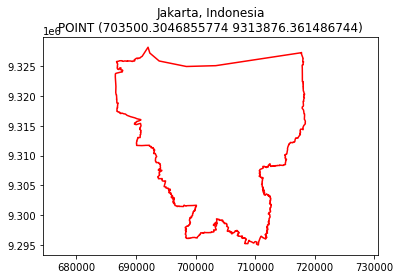

In [8]:
import warnings
warnings.filterwarnings('ignore')

x,y = shp_city_land.boundary.xy
epsg = wgs2epsg(x[0], y[0])

#  EPSG:32748 is also known as WGS 84 / UTM zone 48S

# set projections
project_wgs2utm = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:{}'.format(epsg)))

project_utm2wgs = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:{}'.format(epsg)), # from
    pyproj.Proj(init='epsg:4326'))            # to

shp_city_land_utm = transform(project_wgs2utm, shp_city_land)


x,y = shp_city_land_utm.exterior.xy
plt.plot(x,y,color = 'r')
plt.axis('equal')

plt.title(str(city_query) + '\n' + str(shp_city_land_utm.centroid))

plt.show()

In [9]:
import geopandas

In [10]:
geojson_poly = geopandas.GeoSeries([shp_city_land]).__geo_interface__

In [11]:
gdf = geopandas.GeoDataFrame.from_features(geojson_poly)

gdf.to_file("../../data/rasters_waterbodies_osm/cities/{}_wgs.geojson".format(city_name), driver='GeoJSON')